# Tuning Empirical Gaussian Model to SCADA

In this notebook, we will tune the Empirical Gaussian Model (emgauss) to align with SCADA data. The core parameters of interest in this tuning are 'wake_expansion_rates' and 'horizontal_deflection_gain_D'.

wake_expansion_rates => (basline case)

horizontal_deflection_gain_D => (wake steering case)

In [1]:
import os
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from time import perf_counter as timerpc

from flasc import floris_tools as ftools
from flasc.energy_ratio import energy_ratio_suite
from flasc.dataframe_operations import dataframe_manipulations as dfm
from flasc.visualization import plot_floris_layout, plot_layout_only, plot_layout_with_waking_directions, plot_binned_mean_and_ci

from floris.tools import FlorisInterface
from floris.tools import ParallelComputingInterface
from floris.tools.visualization import visualize_cut_plane, plot_rotor_values

from flasc.model_estimation.tune_floris import FlorisTuner

# from models import load_smarteole_floris

In [2]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Task 1: Analyze Energy Ratios During Wake Steering 

# Load SCADA

Load pre-processed SCADA data with power curve fiiltering and northing calibration applied, and inspect the data.

In [3]:
def load_scada():
    scada_path = os.path.join(Path.cwd(), "postprocessed", "df_scada_data_60s_filtered_and_northing_calibrated.ftr")
    df_scada = pd.read_feather(scada_path)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada

In [4]:
# Load SCADA dataframe
df_scada = load_scada()

In [5]:
# Preview SCADA
df_scada.describe()

,time,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,ws_000,ws_001,...,wd_004,wd_005,wd_006,wind_vane_005,target_yaw_offset_005,wd_smarteole,ws_smarteole,pow_ref_smarteole,ti,wd
count,134661,107990.000000,104834.000000,91602.000000,100703.000000,104591.000000,100064.000000,105990.000000,107990.000000,104834.000000,...,104591.000000,100064.000000,105990.000000,100064.000000,100064.000000,131704.000000,131699.000000,130266.000000,1.346610e+05,115694.000000
mean,2020-04-04 18:49:02.648873472,777.653931,722.490112,787.805054,650.537537,708.335510,711.493103,734.078857,7.992405,7.442919,...,148.641602,152.192139,146.140839,0.822919,0.783870,147.975891,7.286751,639.086548,1.100000e-01,147.147975
min,2020-02-17 16:30:00,0.001000,0.003000,0.002000,0.009000,0.007000,0.032000,0.000000,1.483000,2.746000,...,0.022003,0.009750,0.192000,-43.056999,-0.000000,0.005936,0.101000,-45.498859,1.100000e-01,0.035300
25%,2020-03-12 01:51:00,235.364014,214.135498,246.605499,193.113007,205.125000,174.702759,219.265747,6.128000,5.578000,...,50.771000,52.388748,49.512001,-5.913000,-0.000000,47.813656,5.121595,98.970131,1.100000e-01,47.626443
50%,2020-04-04 10:58:00,571.507019,528.515503,592.422974,467.604004,501.115997,508.388489,540.299988,7.448000,7.027000,...,129.255997,159.308258,135.268494,0.185000,-0.000000,138.522034,7.423318,422.463989,1.100000e-01,136.650682
75%,2020-04-27 20:03:00,1238.221802,1120.502441,1242.167236,997.825989,1085.923462,1133.235962,1132.259033,9.587000,8.945000,...,235.914993,234.888504,232.869751,6.917000,0.000000,235.295441,9.361652,1049.996338,1.100000e-01,233.836438
max,2020-05-24 23:59:00,2064.696045,2065.387939,2051.489990,2062.987061,2063.420898,2078.750977,2076.895996,20.851999,21.240999,...,359.997009,359.980743,359.989014,59.181999,20.000000,359.991791,20.422459,2147.802246,1.100000e-01,359.957791
std,NaN,639.254761,609.922241,636.098022,560.755066,612.281738,624.734497,617.581970,2.547888,2.501712,...,99.421783,97.336273,97.354767,10.042883,3.210437,101.749596,3.104111,629.421387,8.326704e-17,100.092758


In [6]:
# Observe SCADA columns
df_scada.columns

Index(['time', 'pow_000', 'pow_001', 'pow_002', 'pow_003', 'pow_004',
       'pow_005', 'pow_006', 'ws_000', 'ws_001', 'ws_002', 'ws_003', 'ws_004',
       'ws_005', 'ws_006', 'wd_000', 'wd_001', 'wd_002', 'wd_003', 'wd_004',
       'wd_005', 'wd_006', 'is_operation_normal_000',
       'is_operation_normal_001', 'is_operation_normal_002',
       'is_operation_normal_003', 'is_operation_normal_004',
       'is_operation_normal_005', 'is_operation_normal_006', 'wind_vane_005',
       'target_yaw_offset_005', 'control_mode', 'wd_smarteole', 'ws_smarteole',
       'pow_ref_smarteole', 'ti', 'wd'],
      dtype='object')

# Evaluate Offsets

Compare the targeted offsets against what was achieved (as measured by the vane on the steering turbine SMV6 (index=5))

In [7]:
# Offsets
start_of_offset = 200 # deg
end_of_offset = 240 # deg

[6, 8, 10, 12]
wind speeds: 0, 6
control mode: 0, baseline
ax: Axes(0.125,0.712609;0.352273x0.167391)
control mode: 1, controlled
ax: Axes(0.547727,0.712609;0.352273x0.167391)
wind speeds: 1, 8
control mode: 0, baseline
ax: Axes(0.125,0.511739;0.352273x0.167391)
control mode: 1, controlled
ax: Axes(0.547727,0.511739;0.352273x0.167391)
wind speeds: 2, 10
control mode: 0, baseline
ax: Axes(0.125,0.31087;0.352273x0.167391)
control mode: 1, controlled
ax: Axes(0.547727,0.31087;0.352273x0.167391)
wind speeds: 3, 12
control mode: 0, baseline
ax: Axes(0.125,0.11;0.352273x0.167391)
control mode: 1, controlled
ax: Axes(0.547727,0.11;0.352273x0.167391)


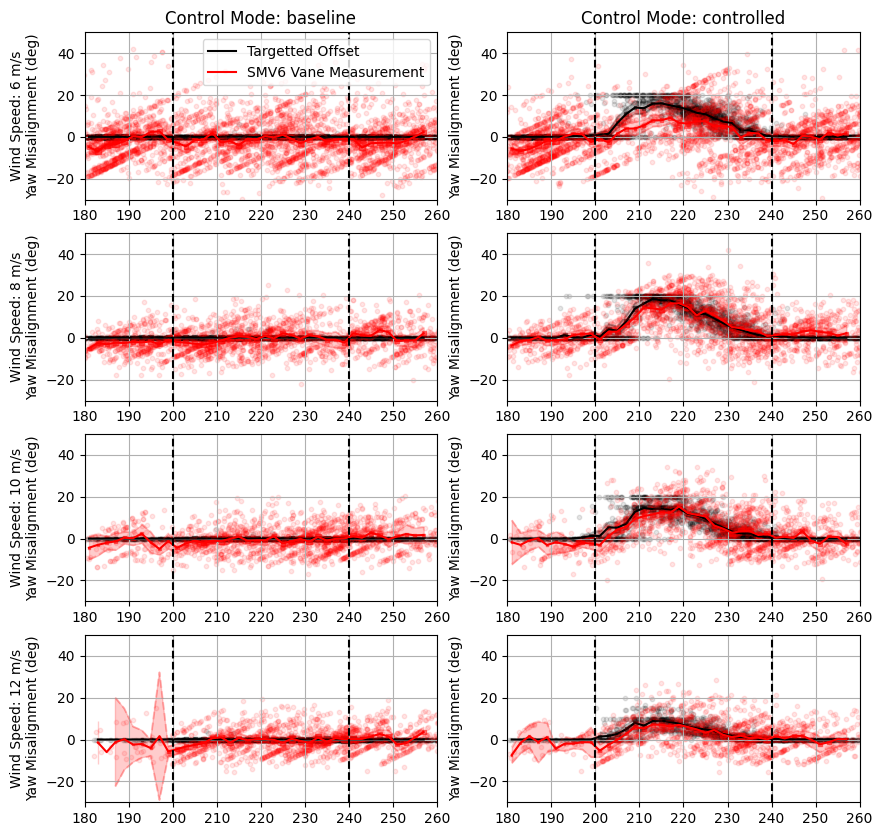

In [8]:
# Add a rounded ws column
df_scada = df_scada.assign(
    ws_round = df_scada.ws_005.round(),
    wd_to_plot = df_scada.wd_005
 )

# Limit to a few wind speeds for plotting
wind_speeds_to_plot = [6,8,10,12]
df_plot = df_scada[df_scada.ws_round.isin(wind_speeds_to_plot)]

# Melt together targeted and achieved 
df_plot = (df_plot
    [['wd_to_plot','ws_round','target_yaw_offset_005','wind_vane_005','control_mode']]
    # .melt(id_vars=['wd_round','ws_round','control_mode'],
    #       var_name='offset_type',
    #       value_name='offset_value')
    .sort_values(['wd_to_plot','ws_round'])
)

# Set up binning plots
x_edges = np.arange(start_of_offset - 20, end_of_offset + 20, 2)

fig, axarr = plt.subplots(len(wind_speeds_to_plot),2, figsize=(10,10))
print(wind_speeds_to_plot)
for ws_idx, ws in enumerate(wind_speeds_to_plot):
    print(f"wind speeds: {ws_idx}, {ws}")
    for c_idx, control_mode in enumerate(['baseline','controlled']):
        print(f"control mode: {c_idx}, {control_mode}")
        ax = axarr[ws_idx, c_idx]
        print(f"ax: {ax}")
        df_sub = df_plot[(df_plot.ws_round==ws) & (df_plot.control_mode==control_mode)]

        plot_binned_mean_and_ci(df_sub.wd_to_plot,
                                df_sub.target_yaw_offset_005,
                                color='k',
                                x_edges=x_edges,
                                label='Targetted Offset',
                                ax=ax
                                 )
        
        plot_binned_mean_and_ci(df_sub.wd_to_plot,
                                df_sub.wind_vane_005,
                                color='r',
                                x_edges=x_edges,
                                label='SMV6 Vane Measurement',
                                ax=ax
                                 )
        
        ax.set_xlim([start_of_offset-20,end_of_offset+20])
        ax.set_ylim([-30, 50])
        ax.grid(True)
        ax.axvline(start_of_offset,color='k',ls='--')
        ax.axvline(end_of_offset,color='k',ls='--')

        if ws_idx == 0:
            ax.set_title(f'Control Mode: {control_mode}')

        if c_idx == 0:
            ax.set_ylabel(f'Wind Speed: {ws} m/s\nYaw Misalignment (deg)')
        else:
            ax.set_ylabel('Yaw Misalignment (deg)')

        if (ws_idx == 0) and (c_idx == 0):
            ax.legend()


In [9]:
# Limit the data to this region
df_scada = df_scada[(df_scada.wd_smarteole > (start_of_offset - 20)) &
                    (df_scada.wd_smarteole < (end_of_offset + 20))]

# Prepare SCADA for Computing Energy Ratios

The energy ratio class as presently implemented requires explicit identification of the dataframe of the reference wind direction, wind speed, and power columns: "wd," "ws," and "pow_ref." Here, we will set these equal to the reference variables used in the SMARTEOLE wake steering experiment, which we computed in "02_download_and_format_dataset.ipynb".

In [10]:
# Assign wd, ws and pow ref
# Subset dataframe
df_scada = (df_scada
    .assign(
        wd = lambda df_: df_['wd_smarteole'],
        ws = lambda df_: df_['ws_smarteole'],
        pow_ref = lambda df_: df_['pow_ref_smarteole']
    )
)

In [11]:
# Split df_scada into baseline and wake steeering on "controlled"
# periods
df_scada_baseline = df_scada[df_scada.control_mode=='baseline']
df_scada_control = df_scada[df_scada.control_mode=='controlled']

# Compare with FLORIS

Compare the observed energy ratios and energy ratio gains for baseline and wake steering control based on SCADA data to the equivalent FLORIS predictions.

# Comparison Assuming No Wind Direction Uncertainty/Variability (FLORIS)

Compute FLORIS predictions of power production for the time series of reference wind directions and wind speeds in the SCADA data set, using the Empirical Gauss wake model. The yaw misalignment of the steered turbine, SMV6 (005), is set to the measured wind vane angle at each timestamp. Yaw misalignments for all other turbines are set to 0.

In [12]:
# Specify emgauss model
wake_model = 'emgauss'

# Load input yaml
yaml = "floris_input/emgauss.yaml"
fi = FlorisInterface(yaml)

# Define D
D = fi.floris.farm.rotor_diameters[0]

In [13]:
floris_tuner = FlorisTuner(fi=fi,
                           df_scada=df_scada_baseline, 
                           num_turbines=7, 
                           test_turbine=[4]) 

In [14]:
df_floris = floris_tuner.get_floris_df(fi=fi, 
                                       pow_ref_columns=[0, 1, 2, 6])

In [15]:
df_floris.columns

Index(['pow_000', 'pow_001', 'pow_002', 'pow_003', 'pow_004', 'pow_005',
       'pow_006', 'ws', 'wd', 'pow_ref'],
      dtype='object')

In [16]:
df_floris.describe()

,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,ws,wd,pow_ref
count,21995.000000,21995.000000,21995.000000,21995.000000,21995.000000,21995.000000,21995.000000,8057.000000,8061.000000,21995.000000
mean,900.663432,908.965390,892.973899,873.489224,782.382893,924.385461,929.414980,9.954214,226.014694,908.004425
std,693.250273,690.807159,697.065288,701.723311,681.503650,685.905737,685.527025,2.467123,19.563507,689.580340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.503500,180.008224,0.000000
25%,213.995141,225.091007,190.931549,159.522628,144.477707,255.521173,263.101771,8.633764,211.222656,232.506606
50%,869.210527,884.775270,860.647476,814.328147,603.494574,914.352797,919.103966,9.943355,226.602341,881.909232
75%,1526.970834,1528.516506,1524.419430,1515.010038,1412.620124,1532.755269,1539.323074,11.381992,242.769241,1527.255496
max,2050.003965,2050.003965,2050.003965,2050.003965,2050.003949,2050.003965,2050.003965,20.422459,259.978241,2050.003965


In [17]:
# err, scada_er, floris_er = floris_tuner.tune_floris(case='baseline',
#                          tolerance=0.062, 
#                          pow_ref_columns=[0, 1, 2, 6],
#                          wd_step=2.0,
#                          ws_step=1.0,
#                          wd_bin_width=2.0)

# # plot_title='Downstream Turbine: SMV5 (004)'                    

In [18]:
err = floris_tuner.tune_floris(case='baseline',
                         tolerance=0.063,
                         pow_ref_columns=[0, 1, 2, 6],
                         mod_rate=0.1,
                         wd_step=2.0,
                         ws_step=1.0,
                         wd_bin_width=2.0,
                         verbose=False)

                    

Dataframes differ in wd and ws. Rebalancing.


In [19]:
# err = floris_tuner.tune_floris(case='baseline',
#                          tolerance=0.062,
#                          pow_ref_columns=[0, 1, 2, 6],
#                          mod_rate=0.001,
#                          wd_step=2.0,
#                          ws_step=1.0,
#                          wd_bin_width=2.0,
#                          verbose=False)

In [20]:
floris_tuner.visualize_scada_comparison(case='baseline',
             title='Downstream Turbine: SMV5 (004)',
             pow_ref_columns=[0, 1, 2, 6],
             wd_step=2.0,
             ws_step=1.0,
             wd_bin_width=2.0)

AttributeError: 'NoneType' object has no attribute 'reinitialize'

## Subtask 1: Manipulate wake_expansion_rates

## Subtask 2: Manipulate horizontal_deflection_gain